<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Quickstart: Web Cam Image Similarity

Image similarity is the cononical computer vision task of measuring similarity between two images, e.g. to build image retrieval systems. A simple but quite powerful approach is to use the output of image classification CNNs to represent an image (e.g. a vector of 512 floating point number), and to define similarity between two images as the e.g. L2 distance between the respective DNN representations.

This is the approach taken in this notebook. More accurate similarity measures are based on DNNs which are trained explicitly for image similarity, such as the [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) work which uses an [Siamese network](https://en.wikipedia.org/wiki/Siamese_network) architecture. 

## Prerequisite for Webcam example 
This notebook assumes you have **a webcam** connected to your machine. We use the `ipywebrtc` module to show the webcam widget in the notebook. Currently, these widgets work on **Chrome** and **Firefox**. For more details about the widget, please visit `ipywebrtc` [github](https://github.com/maartenbreddels/ipywebrtc) or [doc](https://ipywebrtc.readthedocs.io/en/latest/).

## Initialization

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")
sys.path.append("../..")
import io
import os
import time

import fastai
from fastai.vision import models, open_image, ImageList, cnn_learner #load_learner
from ipywebrtc import CameraStream, ImageRecorder
from ipywidgets import HBox, Label, Layout, widgets, Widget

from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor
from utils_cv.classification.data import Urls
from utils_cv.classification.model import model_to_learner

#import utils_is
from utils_is.metrics import compute_topk_similar
from utils_is.utils import plot_similars, SaveFeatures

print(f"Fast.ai: {fastai.__version__}")
#which_processor()

Fast.ai: 1.0.48


# Image retrieval

This notebook shows a simple example of how to build an image retrieval system. Given a *query* image, the goal is to find all similar images in a *reference* set. This is implemented using the following steps:
1. Compute the DNN embeddings for all *reference* images and store on disk.
2. Compute the DNN embedding for the *query* image.
3. Evaluate the L2 distance between the query embedding and all reference embeddings.
4. Return the images with lowest distance or with distance lower than a specified threshold.

Here, we use a pre-trained [ResNet](https://arxiv.org/abs/1512.03385) model using the `fastai.vision` package, alternatively the user can also bring their own trained models. For more details about image classification, including transfer-learning, please see the notebooks in the [classification](../clasification) folder.

## Load images and model
First, we specify the query image and the reference images.

In [3]:
IM_SIZE = 300 #image size in pixels. Reduce to speed up demo.

# Set path to query and reference images
im_path = unzip_url(Urls.fridge_objects_path, exist_ok=True)
query_im_path = os.path.join(im_path,"can/1.jpg")
ref_im_path = os.path.join(im_path,"can")
print(f"Query image path = {query_im_path}")
print(f"Reference images directory = {ref_im_path}")

# Construct a DataBunch 
ref_data = (ImageList.from_folder(ref_im_path)
        .split_none()
        .label_from_folder()
        .transform(tfms=None,size=IM_SIZE)
        .databunch(bs=2))

Query image path = C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\can/1.jpg
Reference images directory = C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\can


Next we load the model

In [4]:
# Load pre-trained model, alternatively one can load a custom model using fastai.vision.load_learner().
#learn = load_learner("../ComputerVision/similarity/notebooks/")
learn = cnn_learner(ref_data, models.resnet18, pretrained=True)

## Featurization of reference images
In this section we evaluate the DNN for each reference image and use the output of the penultimate layer To represent the image. 

In [5]:
# Specify which DNN layer to use as embedding (here: penultimate layer)
target_layer = learn.model[1][6]
featurizer = SaveFeatures(target_layer) 

# Compute DNN embeddings for the reference set
learn.get_preds(ref_data.train_ds)
ref_features = featurizer.features
ref_im_paths = [str(x) for x in list(ref_data.train_ds.items)]
ref_feature_dict = dict(zip(ref_im_paths, ref_features))

print("Computed DNN features for {} images, each consisting of {} floating point values.".format(*ref_features.shape))

Computed DNN features for 32 images, each consisting of 512 floating point values.


## Image retrieval from file
First, we load a *query* image and find the most similar images within the *reference* set using the model.

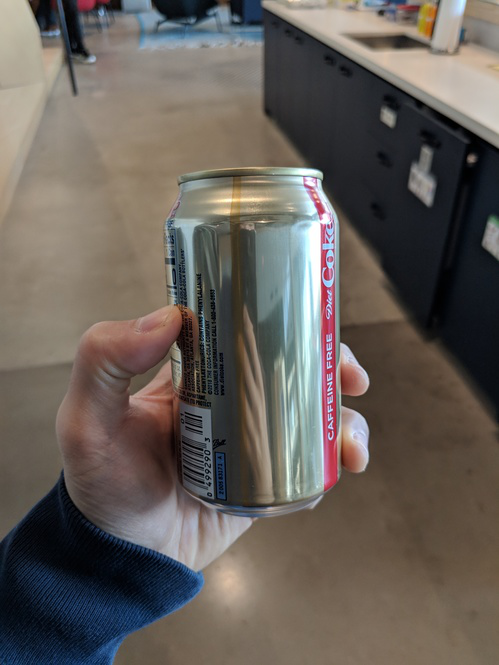

In [6]:
query_im = open_image(query_im_path, convert_mode='RGB')
query_im

In [7]:
# Use the model to predict the class label
start_time = time.time()
featurizer.features = None
_ = learn.predict(query_im)
query_features = featurizer.features

# Show prediction time
print(f"Computing the DNN representation for the query image took {time.time()-start_time:.4f} sec")

Computing the DNN representation for the query image took 0.3660 sec


Top most similar image with L2 distance of 0.00: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\can\1.jpg
Second most similar image with L2 distance of 11.27: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\can\3.jpg


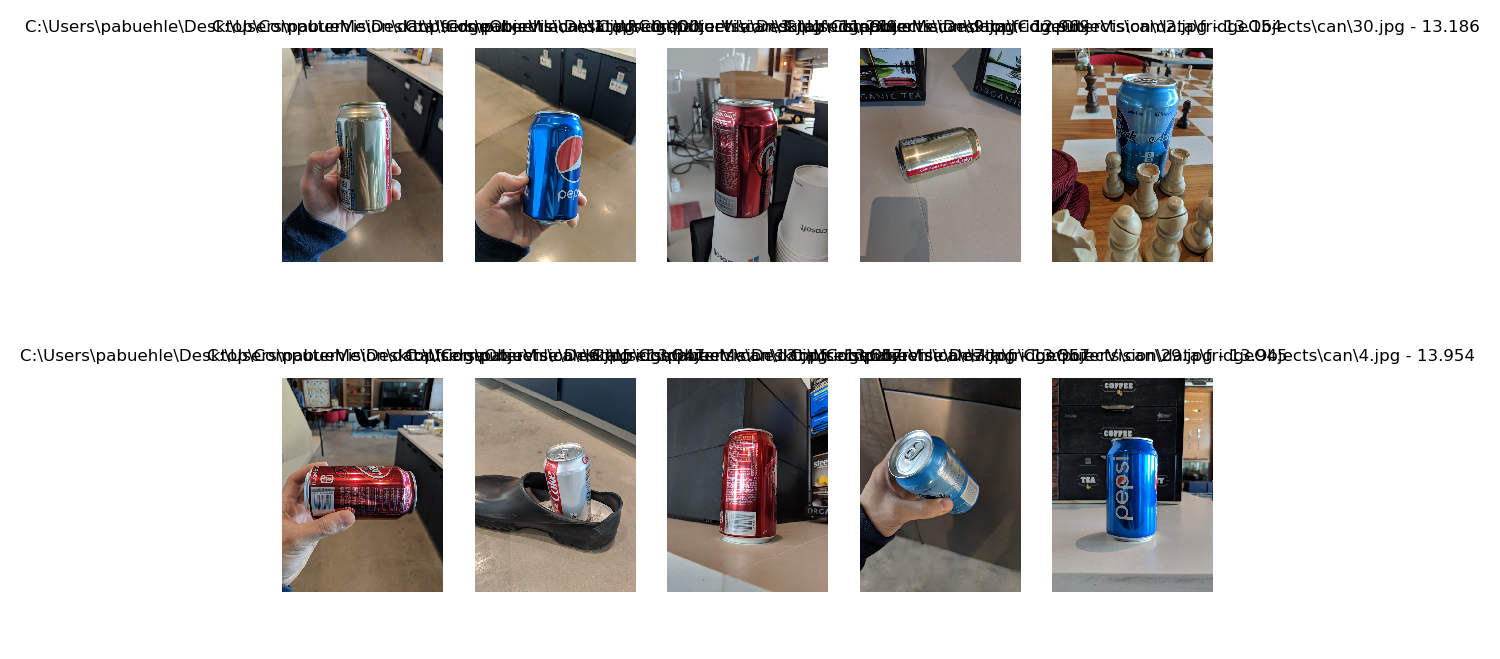

In [8]:
# Compute distance between the query image and all reference images
similars = compute_topk_similar(query_features, ref_feature_dict, distance="l2", top_k=10) #, query_features = query_features)
print("Top most similar image with L2 distance of {:.2f}: {}".format(similars[0][1],similars[0][0]))
print("Second most similar image with L2 distance of {:.2f}: {}".format(similars[1][1],similars[1][0]))
plot_similars(similars) #, num_rows=2, num_cols=4)

## Image retrieval from webcam footage

Now, we use a WebCam stream for image retrieval. We use `ipywebrtc` to start a webcam and get the video stream which is sent to the notebook's widget.

In [9]:
# Webcam
w_cam = CameraStream(
    constraints={
        'facing_mode': 'user',
        'audio': False,
        'video': { 'width': IM_SIZE, 'height': IM_SIZE }
    },
    layout=Layout(width=f'{IM_SIZE}px')
)
# Image recorder for taking a snapshot
w_imrecorder = ImageRecorder(stream=w_cam, layout=Layout(padding='0 0 0 50px'))
# Label widget to show our classification results
w_label = Label(layout=Layout(padding='0 0 0 50px'))

#w_im_path = Label() #layout=Layout(padding='0 0 0 50px'))
w_im = widgets.Image()


def classify_frame(_):
    """ Classify an image snapshot by using a pretrained model
    """
    # Once capturing started, remove the capture widget since we don't need it anymore
    if w_imrecorder.layout.display != 'none':
        w_imrecorder.layout.display = 'none'
        
    try:
        im = open_image(io.BytesIO(w_imrecorder.image.value), convert_mode='RGB')
        
        #_, ind, prob = learn.predict(im)
        featurizer.features = None
        _, ind, prob = learn.predict(query_im)
        query_features = featurizer.features
        
        similars = compute_topk_similar(query_features, ref_feature_dict, distance=DISTANCE, top_k=1)
        im_path, distance = similars[0]
        #print(im_path)
        
        
        # Show result label and confidence
        w_label.value = im_path #"TEST"+str(im_path)+"AAA" # f"{labels[ind]} ({prob[ind]:.2f})"
        w_im.value = open(im_path, "rb").read()
    except OSError:
        # If im_recorder doesn't have valid image data, skip it. 
        pass
    
    # Taking the next snapshot programmatically
    w_imrecorder.recording = True

# Register classify_frame as a callback. Will be called whenever image.value changes. 
w_imrecorder.image.observe(classify_frame, 'value')

In [10]:
# Show widgets
HBox([w_cam, w_imrecorder, w_label, w_im])

Now, click the **capture button** in the widget to start image retrieval. The most similar reference image is shown along with the distance to the query image given by a webcam frame.

<img src="https://cvbp.blob.core.windows.net/public/images/cvbp_webcam.png" width="400" />
<center>
<i>Webcam image classification example</i>
</center>

# Conclusion
In this notebook, we used a simple example to demonstrate how to use a pretrained model to build an image retrieval system. The model is train on object labels that are part of the ImageNet training samples and hence will only work well for such objects. From our [01_training_and_evaluation_introduction notebook](01_training_and_evaluation_introduction.ipynb), you can find how to fine-tune and customize the model to also perform well for other objects that you may be interested in.

In [11]:
# Stop the model and webcam
Widget.close_all()